`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2021/2022`   



# Лабораторная работа №3: Линейные модели. Кросс-валидация. 
### Работу выполнила студентка группы ПМИ3-1 Марахова Екатерина, вариант №13

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (LOOCV, проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Carseats` (источник: <https://github.com/aksyuk/MTML/blob/main/Labs/data/Carseats.csv>)

    
## Список столбцов файла:
`Sales` - продажи (в тысячах штук) в каждом магазине;

`CompPrice` - цена конкурента в каждом магазине;

`Income` - уровень дохода сообщества (в тысячах долларов);

`Advertising` - бюджет местной рекламы для компании в каждом магазине (в тысячах долларов);

`Population` - численность населения в регионе (в тысячах);

`Price` - цены компании на автокресла на каждом магазине;

`ShelveLoc` - качество стеллажа для размещения автокресел в каждом магазине: 
    `Bad` - плохое размещение, `Good` - хорошее и `Medium` - среднее;

`Age` - средний возраст местного населения;

`Education` - уровень образования в городе размещения магазина;

`Urban` - урбанизация: `No` - сельская местность, `Yes` - город;
    
`US` - находится ли магазин в США: `Yes` если да, `No` если нет.    
    
#### Непрерывные объясняющие переменные `Price` и `Income`

#### Дискреные объясняющие переменные `ShelveLoc`

In [241]:
# настройка ширины страницы блокнота .......................................
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Ход работы.


## Загружаем пакеты

In [242]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [243]:
# константы
#  ядро для генератора случайных чисел
my_seed = 13
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Carseats` в формате .csv доступен для загрузки по адресу: <https://github.com/aksyuk/MTML/blob/main/Labs/data/Carseats.csv>.  
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [244]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/Carseats.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 11)


In [245]:
# первые 5 строк фрейма
DF_raw.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [246]:
# типы столбцов фрейма
DF_raw.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

Проверим, нет ли в таблице пропусков.  

In [247]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

Пропусков не обнаружено.  

In [248]:
#категориальные переменные:
#ShelveLoc - качество размещения автокресел в каждом магазине:
    #Bad - плохое размещение, Good - хорошее и Medium - среднее;
#Urban - урбанизация: No - сельская местность, Yes - город;
#US - находится ли магазин в США: Yes если да, No если нет.

# кодируем категориальные переменные
#урбанизация
urban_dict = {'Yes' : 1, 'No' : 0}
DF_raw['UrbanYes'] = DF_raw.Urban.map(urban_dict)

#находится ли магазин в США
us_dict = {'Yes' : 1, 'No' : 0}
DF_raw['USYes'] = DF_raw.US.map(us_dict)

#уникальное знаечние по качеству размещения на стеллажах
DF_raw['ShelveLoc'].unique()

array(['Bad', 'Good', 'Medium'], dtype=object)

In [249]:
#  добавляем фиктивные на качество размещения: число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first=True)
df_dummy.head(5)

,ShelveLoc_Good,ShelveLoc_Medium
0,0,0
1,1,0
2,0,1
3,0,1
4,0,0


In [250]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(400, 15)

In [251]:
# смотрим первые 8 столбцов
DF_all.iloc[:, :8].head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age
0,9.50,138,73,11,276,120,Bad,42
1,11.22,111,48,16,260,83,Good,65
2,10.06,113,35,10,269,80,Medium,59
3,7.40,117,100,4,466,97,Medium,55
4,4.15,141,64,3,340,128,Bad,38


In [252]:
# смотрим последние 5 столбцов
DF_all.iloc[:, 8:].head(5)

,Education,Urban,US,UrbanYes,USYes,ShelveLoc_Good,ShelveLoc_Medium
0,17,Yes,Yes,1,1,0,0
1,10,Yes,Yes,1,1,1,0
2,12,Yes,Yes,1,1,0,1
3,14,Yes,Yes,1,1,0,1
4,13,Yes,No,1,0,0,0


In [253]:
# оставляем в наборе данных только то, что нужно 
DF_all = DF_all[['Sales', 'Income', 'Price', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'ShelveLoc']]

# перекодируем качество в числовой фактор, 
# чтобы использовать на графиках
class_le = LabelEncoder()
DF_all['ShelveLoc'] = class_le.fit_transform(DF_all.ShelveLoc.values)

DF_all.columns

Index(['Sales', 'Income', 'Price', 'ShelveLoc_Good', 'ShelveLoc_Medium',
       'ShelveLoc'],
      dtype='object')

In [254]:
DF_all.dtypes

Sales               float64
Income                int64
Price                 int64
ShelveLoc_Good        uint8
ShelveLoc_Medium      uint8
ShelveLoc             int64
dtype: object

In [255]:
DF_all.head(5)

,Sales,Income,Price,ShelveLoc_Good,ShelveLoc_Medium,ShelveLoc
0,9.50,73,120,0,0,0
1,11.22,48,83,1,0,1
2,10.06,35,80,0,1,2
3,7.40,100,97,0,1,2
4,4.15,64,128,0,0,0


In [256]:
# удаляем фрейм-исходник
del DF_raw

Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [257]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных(`ShelveLoc` - дискретная).

Из таблицы ниже можно видеть, что переменная `Price` имеет больший масштаб нежели остальные, а зависимая `Sales` единственная, кто приминает нулевое значение.

In [258]:
# описательные статистики для непрерывных переменных
DF[['Sales', 'Price', 'Income']].describe()

,Sales,Price,Income
count,320.000000,320.000000,320.00000
mean,7.518031,115.168750,69.25000
std,2.831121,24.056288,27.32482
min,0.000000,24.000000,21.00000
25%,5.360000,99.000000,45.00000
50%,7.475000,117.000000,69.00000
75%,9.342500,130.000000,90.00000
max,15.630000,191.000000,120.00000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

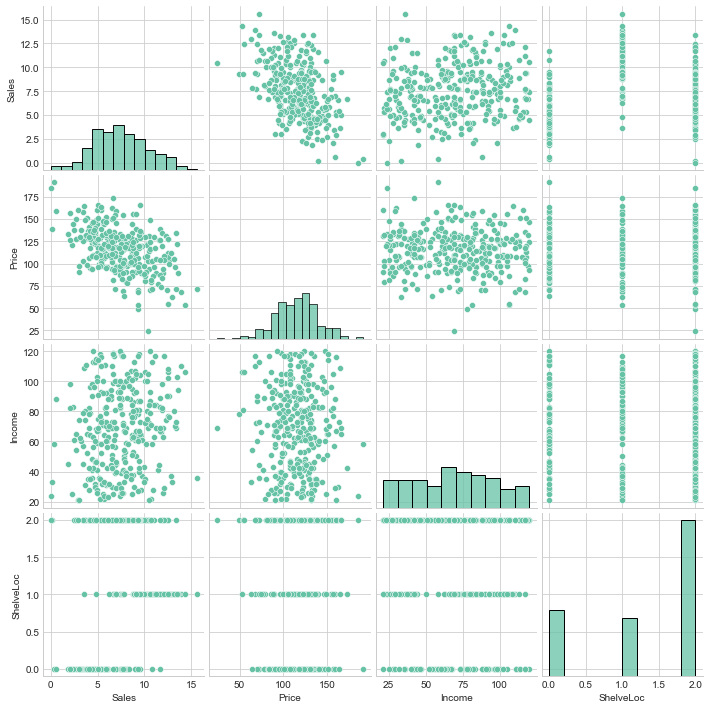

In [259]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['Sales', 'Price', 'Income', 'ShelveLoc']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `Sales` стремится к нормальному, как и `Price`;  
* из всех объясняющих равномерно распределена только `Income`;
* объясняющая `ShalveLoc` дискретна;
* разброс значений `Income`, где качество размещения автокресел в каждом магазине среднее(максимум из таблицы выше), больше, чем у остальных.  

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от качества размещения.  

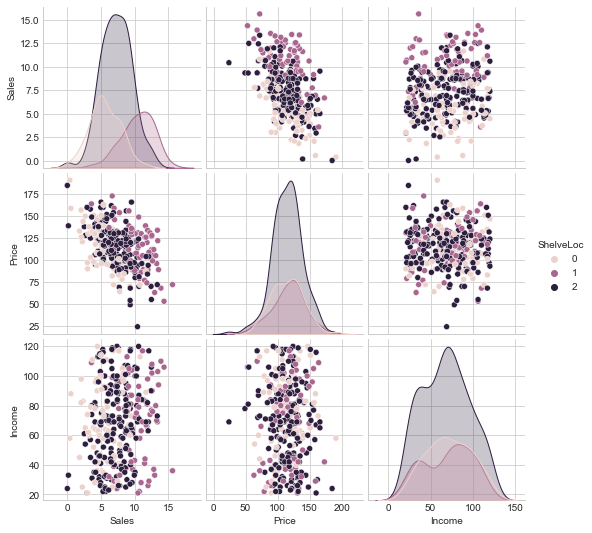

In [260]:
# матричный график разброса с цветом по качеству размещения(ShelveLoc).
sns.pairplot(DF[['Sales', 'Price', 'Income', 'ShelveLoc']],
            hue='ShelveLoc')

plt.show()

Заметим, что уровень продаж и дохода в местах, где размещение среднего уровня, намного выше, чем в других. Цена тоже выше: то есть для продажи автокресел вполне подходит размещение сдреднего качества.

In [261]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['Sales', 'Price', 'Income']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Income
Sales,1.00,-0.46,0.15
Price,-0.46,1.00,-0.05
Income,0.15,-0.05,1.00


По данному графику можно увидеть, что здесь есть небольшая взаимосвязь между продажами в каждом магазине `Sales` и уровнем дохода сообщества `Income`, остальные переменные практически ни на что не влияют.

Посчитаем корреляционные матрицы для размещения среднего и хорошего качества.

In [262]:
# корреляционная матрица по среднему классу качества размещения 
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales', 'Price', 'Income']].corr()
#corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales', 'Price', 'Income', 'ShelveLoc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Income
Sales,1.00,-0.56,0.24
Price,-0.56,1.00,-0.14
Income,0.24,-0.14,1.00


In [263]:
# корреляционная матрица по хорошему классу качества размещения 
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales', 'Price', 'Income']].corr()
#corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales', 'Price', 'Income', 'ShelveLoc']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Income
Sales,1.00,-0.62,0.08
Price,-0.62,1.00,0.11
Income,0.08,0.11,1.00


Судя по корреляционным матрицам, не трудно заметить, что при размещении на стеллажах среднего качества сильно меняется взаимосвзь между продажами и уровнем дохода сообщества `Income`: она увеличивается в три раза, что дает преимущество фиктивной переменой `ShelveLoc_Medium` перед `ShelveLoc_Good`, поэтому теперь в приоритете будем рассматривать именно ее.



### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [264]:
DF['Sales']+=0.000001

In [265]:
# логарифмируем зависимую переменную
DF['log_sales'] = np.log(DF['Sales'])

# описательные статистики для непрерывных показателей
DF[['Sales', 'log_sales', 'Price', 'Income']].describe()

,Sales,log_sales,Price,Income
count,320.000000,320.000000,320.000000,320.00000
mean,7.518032,1.879570,115.168750,69.25000
std,2.831121,1.010610,24.056288,27.32482
min,0.000001,-13.815511,24.000000,21.00000
25%,5.360001,1.678964,99.000000,45.00000
50%,7.475001,2.011559,117.000000,69.00000
75%,9.342501,2.234574,130.000000,90.00000
max,15.630001,2.749192,191.000000,120.00000


Проведём формальные тесты на нормальность.  

In [266]:
# тестируем на нормальность
for col in ['Sales', 'log_sales']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

Sales Statistics=0.99, p=0.2380
Распределение нормально (H0 не отклоняется)

log_sales Statistics=0.34, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

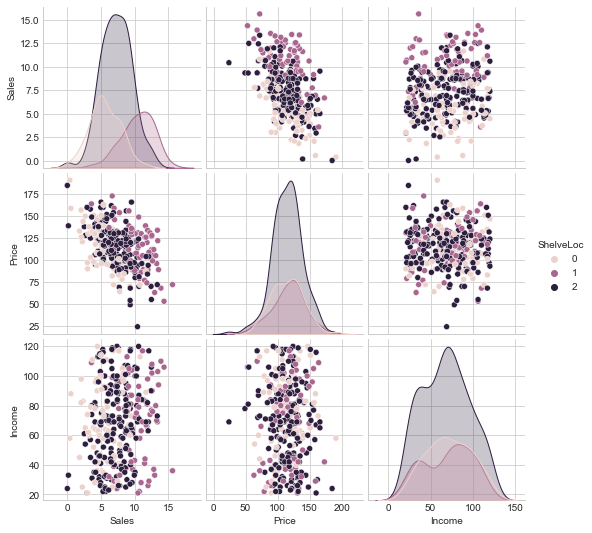

In [267]:
# матричный график разброса с цветом по среднему качеству размещения(ShelveLoc_Medium).
sns.pairplot(DF[['Sales', 'Price', 'Income', 'ShelveLoc']],
            hue='ShelveLoc')

plt.show()

In [268]:
# корреляционная матрица по среднему классу качества размещения 
corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales', 'Price', 'Income']].corr()
#corr_mat = DF.loc[DF['ShelveLoc_Medium'] == 1][['Sales', 'Price', 'Income', 'ShelveLoc']].corr()

corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Income
Sales,1.00,-0.56,0.24
Price,-0.56,1.00,-0.14
Income,0.24,-0.14,1.00


In [269]:
# корреляционная матрица по хорошему классу качества размещения 
corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales', 'Price', 'Income']].corr()
#corr_mat = DF.loc[DF['ShelveLoc_Good'] == 1][['Sales', 'Price', 'Income', 'ShelveLoc']].corr()

corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Sales,Price,Income
Sales,1.00,-0.62,0.08
Price,-0.62,1.00,0.11
Income,0.08,0.11,1.00


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc\_Medium + \hat{\beta_2} \cdot Price + \hat{\beta_3} \cdot Income$
1. `fit_lm_2`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc\_Medium + \hat{\beta_2} \cdot Price \cdot ShelveLoc\_Medium + \hat{\beta_3} \cdot Income$
1. `fit_lm_3`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc\_Medium + \hat{\beta_2} \cdot Income \cdot ShelveLoc\_Medium + \hat{\beta_3} \cdot Price$
1. `fit_lm_4`: $\hat{sales} = \hat{\beta_0} + \hat{\beta_1} \cdot ShelveLoc\_Medium + \hat{\beta_2} \cdot Income \cdot ShelveLoc\_Medium + \hat{\beta_3} \cdot Price \cdot ShelveLoc\_Medium$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_sales}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_sales}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_sales}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_sales}$

Кроме того, добавим в сравнение модели зависимости `Sales` и `log_sales` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [271]:
DF.head(5)

,Sales,Income,Price,ShelveLoc_Good,ShelveLoc_Medium,ShelveLoc,log_sales
67,9.010001,61,115,0,1,2,2.198335
224,4.100001,82,141,0,1,2,1.410987
51,4.420001,90,108,0,0,0,1.486140
7,11.850001,81,120,1,0,1,2.472328
312,6.800001,117,135,0,0,0,1.916923


In [273]:
# данные для моделей 1, 5
df1 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Income']]

# данные для моделей 2, 6
df2 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Income']]
df2.loc[:, 'Price_ShelveLoc_Medium'] = df2.loc[:, 'Price'] * df2.loc[:, 'ShelveLoc_Medium']
df2 = df2.drop(['Price'], axis=1)

# данные для моделей 3, 7
df3 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Income']]
df3.loc[:, 'Income_ShelveLoc_Medium'] = df3.loc[:, 'Income'] * df3.loc[:, 'ShelveLoc_Medium']
df3 = df3.drop(['Income'], axis=1)

# данные для моделей 4, 8
df4 = DF[['Sales', 'ShelveLoc_Medium', 'Price', 'Income']]
df4.loc[:, 'Income_ShelveLoc_Medium'] = df4.loc[:, 'Income'] * df4.loc[:, 'ShelveLoc_Medium']
df4.loc[:, 'Price_ShelveLoc_Medium'] = df4.loc[:, 'Price'] * df4.loc[:, 'ShelveLoc_Medium']
df4 = df4.drop(['Income', 'Price'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_sales', 'ShelveLoc'], axis=1)

In [274]:
# проверка результатов
df0.head(5)

,Sales,Income,Price,ShelveLoc_Good,ShelveLoc_Medium
67,9.010001,61,115,0,1
224,4.100001,82,141,0,1
51,4.420001,90,108,0,0
7,11.850001,81,120,1,0
312,6.800001,117,135,0,0


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `Sales` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [275]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['Sales'], axis=1)
y = df0.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [10.985] 
 объясняющие  ['Income', 'Price', 'ShelveLoc_Good', 'ShelveLoc_Medium'] 
 коэффициенты  [[ 0.014 -0.056  4.943  1.712]]


In [276]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([1.83191313])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [277]:
# модель со всеми объясняющими, y_log
X = df0.drop(['Sales'], axis=1)
y = np.log(df0.Sales).values.reshape(-1, 1) 
fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n',
        'константа ', np.around(fit_lm_0_log.intercept_, 3), 
          '\n объясняющие ', list(X.columns.values),
              '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [2.962] 
 объясняющие  ['Income', 'Price', 'ShelveLoc_Good', 'ShelveLoc_Medium'] 
 коэффициенты  [[ 0.005 -0.015  0.74   0.248]]


In [278]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[  0.5,  -1.5, 109.6,  28.2]])

In [279]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([2.75358643])

In [280]:
len(y_pred)


320

In [281]:
print('MSE_train модели для Sales меньше MSE_train',
     'модели для log(Sales) в ', np.around(MSE_log / MSE, 1), 'раз')

MSE_train модели для Sales меньше MSE_train модели для log(Sales) в  [2.3] раз


### Оценка точности

#### LOOCV  

Сделаем перекрёстную проверку точности моделей по одному наблюдению.  

In [282]:
# LeaveOneOut CV
loo = LeaveOneOut()

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    score = cross_val_score(lm, X, y, cv=loo,
                           scoring='neg_mean_squared_error').mean()    
    scores.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 21.30 секунд


In [283]:
df0.shape

(320, 5)

In [284]:
# модели для y_log
scores_log = list()
# таймер
tic = time.perf_counter()
for df in [df0, df1, df2, df3, df4] :
    loo.get_n_splits(df)
    X = df.drop(['Sales'], axis=1)
    y = np.log(df.Sales)
    score = cross_val_score(lm, X, y, cv=loo, n_jobs=1,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)

# таймер
toc = time.perf_counter()
print(f"Расчёты методом LOOCV заняли {toc - tic:0.2f} секунд")

Расчёты методом LOOCV заняли 20.26 секунд


Сравним ошибки для моделей на исходных значениях `Sales` с ошибками моделей на логарифме.  

In [285]:
scores

[-3.4621208950953557,
 -6.206990638775679,
 -7.038487866910953,
 -6.239003718025049,
 -7.040258737139551]

In [286]:
[np.around(-x, 2) for x in scores]

[3.46, 6.21, 7.04, 6.24, 7.04]

In [287]:
[np.around(-x, 3) for x in scores_log]

[0.871, 0.932, 0.984, 0.935, 0.984]

Определим самые точные модели отдельно на `Sales` и на `log_sales`.  

In [288]:
# самая точная на Sales
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_loocv =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0 :
MSE_loocv = 3.0


In [289]:
# самая точная на log(Sales)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с LOOCV у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_loocv =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0_log :
MSE_loocv = 0.871


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [290]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Sales'], axis=1)
    y = df.Sales
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 1.15 секунд


In [291]:
# Перекрёстная проверка по 10 блокам
folds = 10

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['Sales'], axis=1)
    y = np.log(df.Sales)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.86 секунд


In [292]:
scores

[-3.4490241459111792,
 -6.1601782866747055,
 -7.062614261034537,
 -6.190441092744348,
 -6.9986738219562525]

In [293]:
# самая точная на Sales
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 3.0


In [294]:
# самая точная на log(Sales)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold10 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0_log :
MSE_kf10 = 0.87


Можно убедиться, что оценка MSE методом перекрёстной проверки по 10 блокам даёт результаты, практически идентичные методу LOOCV. При этом скорость у первого метода при 320 наблюдениях выше на два порядка.

Самой точной среди моделей для `Sales` оказалась `fit_lm_0`, а среди моделей для `log_sales` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [297]:
# прогноз по fit_lm_0
#  модель на всех обучающих наблюдениях
X = df0.drop(['Sales'], axis=1)
y = df0.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['Sales']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict
X = X.drop(['Sales', 'ShelveLoc'], axis=1)
#  прогнозы
y_pred = fit_lm_0.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_0 на отложенных наблюдениях = 3.92


In [298]:
# прогноз по fit_lm_log_0
# модель
#df0 = DF.drop(['log_sales', 'ShelveLoc'], axis=1)
X = df0.drop(['Sales'], axis=1)
y = np.log(df0.Sales).values.reshape(-1, 1)
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['Sales']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['Sales', 'ShelveLoc'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 5.26


In [299]:
np.sqrt(MSE_log) / np.mean(DF_predict[['Sales']]) * 100

Sales    30.954052
dtype: float64

In [300]:
np.sqrt(MSE) / np.mean(DF_predict[['Sales']]) * 100

Sales    26.729796
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_0`, которая включает в себя все переменные, кроме `ShelveLoc`.

In [301]:
X = df0.drop(['Sales'], axis=1)
y = df0.Sales.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(df0.drop(['Sales'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель fit_lm_0:
 константа  [10.985] 
 объясняющие  ['Income', 'Price', 'ShelveLoc_Good', 'ShelveLoc_Medium'] 
 коэффициенты  [[ 0.014 -0.056  4.943  1.712]]


## Интерпретация модели
### y = 10.985 + 0.014\*Income - 0.056\*Price + 4.943\*ShelveLoc_Good + 1.712\*ShelveLoc_Medium


#### Ошибка модели на отложенных наблюдениях составила 26.73% от значения Y


* Если объясняющие переменные будут равняться нулю, то Y равен константе = 10.985,
* при увеличении Income на единицу, Y увеличится на 0.014. 
* при увеличении Price на единицу, Y уменьшится на 0.056. 
* при увеличении фиктивной переменной ShelveLoc_Good на единицу, Y увеличится на 4.943, 
* а при увеличении фиктивной ShelveLoc_Medium на единицу, Y увеличится на 1.712.


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  